In [30]:
import pandas as pd
import glob
import re
import string

import warnings
warnings.filterwarnings("ignore")

In [2]:
filelist = glob.glob("csvs/*.csv")

In [3]:
dash = '-' * 90

for i in range(len(filelist)):
    if i == 0:
      print(dash)
      print('{:<40s}{:>20s}{:>20s}'.format('Name','Kommentare Bekommen','Kommentare Zahl'))
      print(dash)
    else:
      df = pd.read_csv(filelist[i-1])
      print('{:<40s}{:>10d}{:>25d}'.format(filelist[i-1], len(df['Kommentare']), df['Zahl der Kommentaren'][0]))

------------------------------------------------------------------------------------------
Name                                     Kommentare Bekommen     Kommentare Zahl
------------------------------------------------------------------------------------------
csvs/KRH Klinikum Lehrte.csv                    87                       87
csvs/Sophienklinik GmbH.csv                    116                      116
csvs/Krankenhaus Lindenbrunn.csv                44                       44
csvs/Asklepios Hospital Göttingen.csv           56                       57
csvs/Augenklinik Dr. Hoffmann.csv              108                      108
csvs/Helios Klinikum Hildesheim.csv            305                      307
csvs/Asklepios Hospital Tiefenbrunn.csv         25                       25
csvs/Krankenhaus Marienstift gGmbH.csv          86                       86
csvs/DIAKOVERE Friederikenstift.csv            264                      264
csvs/DIAKOVERE Annastift.csv                    98   

#### Google Maps CSV's kombinieren

In [4]:
def kombineCSVs(filenames):
    df = pd.concat([pd.read_csv(file, encoding='utf-8') for file in filenames])
    return df

In [5]:
maps_df = kombineCSVs([name for name in filelist])

In [6]:
maps_df.head(3)

,Name,AVG - Sterne,Zahl der Kommentaren,Adresse,Sterne,Kommentare,Datum,Likes
0,KRH Klinikum Lehrte,3.3,87,"Manskestraße 22, 31275 Lehrte",4,(Translated by Google) My father was admitted ...,a month ago,0
1,KRH Klinikum Lehrte,3.3,87,"Manskestraße 22, 31275 Lehrte",5,(Translated by Google) Station 4 is great. I c...,a year ago,2
2,KRH Klinikum Lehrte,3.3,87,"Manskestraße 22, 31275 Lehrte",5,(Translated by Google) Everyone was super nice...,a month ago,0


In [7]:
maps_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1965 entries, 0 to 112
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  1965 non-null   object 
 1   AVG - Sterne          1965 non-null   float64
 2   Zahl der Kommentaren  1965 non-null   int64  
 3   Adresse               1965 non-null   object 
 4   Sterne                1965 non-null   int64  
 5   Kommentare            1445 non-null   object 
 6   Datum                 1965 non-null   object 
 7   Likes                 1965 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 138.2+ KB


In [8]:
maps_df.reset_index(drop=True, inplace=True)

In [9]:
strin = maps_df['Kommentare'][0]
strin

"(Translated by Google) My father was admitted to the intensive care unit in this hospital. The staff did everything to save him. Thanks alot! You are angels on earth.\nOne star, because the communication wasn't so good and some of the sisters were really unfriendly.\n\n(Original)\nMein Vater ist in diesem KH in die Intensivstation eingeliefert worden. Das Personal hat alles getan um.ihn zu retten. Vielen vielen Dank! Ihr seid Engel auf Erden.\nEinen Stern Abzug, weil die Kommunikation nicht so gut war und manche Schwestern echt unfreundlich waren."

#### Bearbeiten von Kommentaren, um gute Ergebnisse aus der Sentimentalyse zu erhalten

##### Unterscheidung zwischen englischen und deutschen Kommentaren

In [10]:
def split_it(df, column):
    english = []
    deutsch = []
    komment_list = []
    df['Regex'] =  [re.split(r"\(Translated by Google\)", str(x)) for x in df[column]]
    for kommentar in df['Regex']:
        try:
            komment = kommentar[1]
            komment_list.append(komment)
        except:
            komment = 'No Comment'
            komment_list.append(komment)

    df['Regex'] =  komment_list
    
    df['Regex'] =  [re.split(r"\(Original\)", str(x)) for x in df['Regex']]
    
    for sprache in df['Regex']:
        try:
            eng = sprache[0]
            de = sprache[1]
            english.append(eng)
            deutsch.append(de)
        except:
            komment = 'No Comment'
            english.append(komment)
            deutsch.append(komment)
    df.drop('Regex', axis=1, inplace= True)
    df['Englisch'] =  english
    df['Deutsch'] =  deutsch 
    
    return df['Englisch'], df['Deutsch']

In [11]:
maps_df['Englisch'], maps_df['Deutsch'] = split_it(maps_df, 'Kommentare')

In [12]:
maps_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965 entries, 0 to 1964
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  1965 non-null   object 
 1   AVG - Sterne          1965 non-null   float64
 2   Zahl der Kommentaren  1965 non-null   int64  
 3   Adresse               1965 non-null   object 
 4   Sterne                1965 non-null   int64  
 5   Kommentare            1445 non-null   object 
 6   Datum                 1965 non-null   object 
 7   Likes                 1965 non-null   int64  
 8   Englisch              1965 non-null   object 
 9   Deutsch               1965 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 153.6+ KB


In [13]:
google_maps = maps_df.drop('Kommentare', axis=1)

In [14]:
google_maps.head(2)

,Name,AVG - Sterne,Zahl der Kommentaren,Adresse,Sterne,Datum,Likes,Englisch,Deutsch
0,KRH Klinikum Lehrte,3.3,87,"Manskestraße 22, 31275 Lehrte",4,a month ago,0,My father was admitted to the intensive care ...,\nMein Vater ist in diesem KH in die Intensivs...
1,KRH Klinikum Lehrte,3.3,87,"Manskestraße 22, 31275 Lehrte",5,a year ago,2,Station 4 is great. I came to the emergency r...,\nStation 4 ist super. Ich bin heute Nacht in ...


##### Entfernen unerwünschter Zeichen aus Kommentaren

In [15]:
google_maps['Englisch'].replace(r'\s+|\\n', ' ', regex=True, inplace=True) 
google_maps['Deutsch'].replace(r'\s+|\\n', ' ', regex=True, inplace=True) 

In [16]:
google_maps['Deutsch'][0]

' Mein Vater ist in diesem KH in die Intensivstation eingeliefert worden. Das Personal hat alles getan um.ihn zu retten. Vielen vielen Dank! Ihr seid Engel auf Erden. Einen Stern Abzug, weil die Kommunikation nicht so gut war und manche Schwestern echt unfreundlich waren.'

In [17]:
google_maps['Adresse'].value_counts()

Senator-Braun-Allee 33, 31135 Hildesheim              305
Saint-Maur-Platz 1, 31785 Hameln                      275
Humboldtstraße 5, 30169 Hannover                      264
Lützerodestraße 1, 30161 Hannover                     178
Leipziger Str. 24, 38124 Braunschweig                 140
Bischofsholer Damm 160, 30173 Hannover                116
Fuhrberger Str. 8, 30938 Burgwedel                    113
Wolfenbütteler Str. 82, 38102 Braunschweig            108
Anna-von-Borries-Straße 1-7, 30625 Hannover            98
Manskestraße 22, 31275 Lehrte                          87
Helmstedter Str. 35, 38102 Braunschweig                86
Landrat-Beushausen-Straße 26, 31061 Alfeld (Leine)     70
Rosdorfer Weg 70, 37081 Göttingen                      56
Am Lindenbrunn 1, 31863 Coppenbrügge                   44
Tiefenbrunn, 37124 Rosdorf                             25
Name: Adresse, dtype: int64

## Sentimenanalyse

In [18]:
import textblob # Sentiment Analyse
from textblob_de import TextBlobDE
from textblob import TextBlob

In [19]:
'''Bei diesen Funktionen mit TextBlob werden wir 'Polaritywerten' von allen Kommentaren  erhalten.  '''

def senti_deutsch(x):
    return TextBlobDE(x).sentiment.polarity # TextBlobDE ist für deutsche Texte geignet.

In [ ]:
google_maps.info()

In [20]:
google_maps['Senti_Score'] = google_maps['Deutsch'].apply(senti_deutsch)

In [21]:
google_maps.head()

,Name,AVG - Sterne,Zahl der Kommentaren,Adresse,Sterne,Datum,Likes,Englisch,Deutsch,Senti_Score
0,KRH Klinikum Lehrte,3.3,87,"Manskestraße 22, 31275 Lehrte",4,a month ago,0,My father was admitted to the intensive care ...,Mein Vater ist in diesem KH in die Intensivst...,0.000000
1,KRH Klinikum Lehrte,3.3,87,"Manskestraße 22, 31275 Lehrte",5,a year ago,2,Station 4 is great. I came to the emergency r...,Station 4 ist super. Ich bin heute Nacht in d...,0.462500
2,KRH Klinikum Lehrte,3.3,87,"Manskestraße 22, 31275 Lehrte",5,a month ago,0,Everyone was super nice and helpful. Despite ...,Alle super nett und hilfsbereit. Trotz sponta...,0.100000
3,KRH Klinikum Lehrte,3.3,87,"Manskestraße 22, 31275 Lehrte",5,2 months ago,2,When I read all of this I don't come here for...,Wenn ich das alles hier lese. Ich komme hier ...,0.000000
4,KRH Klinikum Lehrte,3.3,87,"Manskestraße 22, 31275 Lehrte",5,a month ago,0,My husband was operated on by Dr Remerey in O...,Mein Mann wurde im Oktober 2016 von Dr.Fremer...,0.307143


In [22]:
google_maps['Senti_Score'].value_counts()

 0.000000    718
 1.000000    171
 0.500000     89
 0.333333     43
-1.000000     32
            ... 
 0.127778      1
-0.015152      1
 0.064247      1
 0.415625      1
 0.231818      1
Name: Senti_Score, Length: 492, dtype: int64

## Machine Learning

### K-Means Clustering

In [23]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
%matplotlib inline

##### Pre - Processing

Wie gesehen, sind einige Variablen in diesem Datensatz kategoriale Variable. Der k-means-Algorithmus ist nicht direkt auf kategoriale Variablen anwendbar, da die euklidische Distanzfunktion für diskrete Variablen nicht wirklich von Bedeutung ist. Lassen Sie uns diese Funktion löschen und das Clustering ausführen.

In [35]:
maps_ml = google_maps[['Name','Zahl der Kommentaren','Sterne','Likes','Senti_Score']]

In [36]:
maps_ml.head()

,Name,Zahl der Kommentaren,Sterne,Likes,Senti_Score
0,KRH Klinikum Lehrte,87,4,0,0.000000
1,KRH Klinikum Lehrte,87,5,2,0.462500
2,KRH Klinikum Lehrte,87,5,0,0.100000
3,KRH Klinikum Lehrte,87,5,2,0.000000
4,KRH Klinikum Lehrte,87,5,0,0.307143


Erhöhen wir den Effekt der Anzahl der Sterne in der Anzahl der Likes.

In [39]:
maps_ml['Stern_Like'] = maps_ml['Sterne'] * maps_ml['Likes']

In [40]:
maps_ml.head()

,Name,Zahl der Kommentaren,Sterne,Likes,Senti_Score,Stern_Like
0,KRH Klinikum Lehrte,87,4,0,0.000000,0
1,KRH Klinikum Lehrte,87,5,2,0.462500,10
2,KRH Klinikum Lehrte,87,5,0,0.100000,0
3,KRH Klinikum Lehrte,87,5,2,0.000000,10
4,KRH Klinikum Lehrte,87,5,0,0.307143,0


In [44]:
stern_like = maps_ml.groupby('Name')['Stern_Like', 'Likes'].sum()
stern_like

,Stern_Like,Likes
Name,,
AMEOS Hospital Alfeld,258,118
Asklepios Hospital Göttingen,391,209
Asklepios Hospital Tiefenbrunn,134,62
Augenklinik Dr. Hoffmann,322,92
DIAKOVERE Annastift,555,160
DIAKOVERE Friederikenstift,743,396
DRK-Krankenhaus Clementinenhaus,914,239
Helios Klinikum Hildesheim,930,548
Herzogin Elisabeth Hospital,1079,263


In [45]:
stern_like['Avg_Stern'] = stern_like['Stern_Like'] / stern_like['Likes']

In [47]:
sentiment_avg = maps_ml.groupby('Name')['Senti_Score','Zahl der Kommentaren'].mean()

In [48]:
sentiment_avg

,Senti_Score,Zahl der Kommentaren
Name,,
AMEOS Hospital Alfeld,0.178505,70
Asklepios Hospital Göttingen,0.041994,57
Asklepios Hospital Tiefenbrunn,0.054000,25
Augenklinik Dr. Hoffmann,0.394743,108
DIAKOVERE Annastift,0.227656,98
DIAKOVERE Friederikenstift,0.168211,264
DRK-Krankenhaus Clementinenhaus,0.326441,178
Helios Klinikum Hildesheim,0.149909,307
Herzogin Elisabeth Hospital,0.311041,140


In [50]:
cluster_df = pd.concat([stern_like,sentiment_avg], axis=1)

In [53]:
columns_to_drop = ['Stern_Like', 'Likes']

cluster_df = cluster_df.drop(columns_to_drop, axis=1)

In [54]:
cluster_df

,Avg_Stern,Senti_Score,Zahl der Kommentaren
Name,,,
AMEOS Hospital Alfeld,2.186441,0.178505,70
Asklepios Hospital Göttingen,1.870813,0.041994,57
Asklepios Hospital Tiefenbrunn,2.161290,0.054000,25
Augenklinik Dr. Hoffmann,3.500000,0.394743,108
DIAKOVERE Annastift,3.468750,0.227656,98
DIAKOVERE Friederikenstift,1.876263,0.168211,264
DRK-Krankenhaus Clementinenhaus,3.824268,0.326441,178
Helios Klinikum Hildesheim,1.697080,0.149909,307
Herzogin Elisabeth Hospital,4.102662,0.311041,140


In [55]:
clustering = cluster_df.reset_index(drop=True)
clustering

,Avg_Stern,Senti_Score,Zahl der Kommentaren
0,2.186441,0.178505,70
1,1.870813,0.041994,57
2,2.161290,0.054000,25
3,3.500000,0.394743,108
4,3.468750,0.227656,98
5,1.876263,0.168211,264
6,3.824268,0.326441,178
7,1.697080,0.149909,307
8,4.102662,0.311041,140
9,2.020134,0.194117,113


In [56]:
from sklearn.preprocessing import StandardScaler
X = clustering.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-0.13224982, -0.72823701],
       [-1.50815463, -0.88259159],
       [-1.38714354, -1.26254133],
       [ 2.04722196, -0.27704669],
       [ 0.36314251, -0.39578098],
       [-0.23600801,  1.57520831],
       [ 1.35880652,  0.55409337],
       [-0.42047405,  2.08576577],
       [ 1.20358738,  0.10290306],
       [ 0.0251058 , -0.21767954],
       [-0.2725608 , -0.52638871],
       [-0.80007883, -1.03694617],
       [-0.1012936 , -0.53826214],
       [-1.11834299,  1.72956289],
       [ 0.97844211, -0.18205925]])

### Modeling

Es wäre dasselbe wie zu erraten, dass jede Klinikgruppe bestimmte Sterne, Likes, Sentimentswerte usw. mit mehreren Tests und Experimenten haben würde. Mit dem K-Means-Clustering können wir diesen Vorgang jedoch viel einfacher durchführen.

In [70]:
from yellowbrick.cluster import KElbowVisualizer

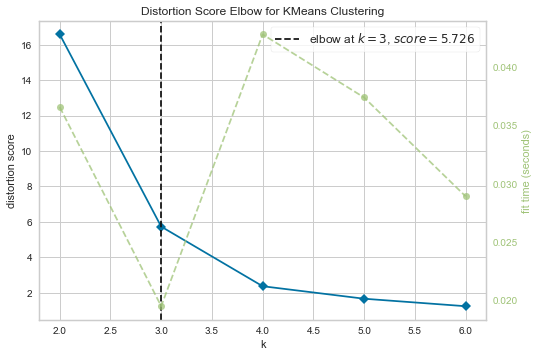

In [72]:
kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k = (2,7))
visu.fit(Clus_dataSet)
visu.poof()

In [73]:
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[0 0 0 2 2 1 2 1 2 2 0 0 0 1 2]


In [74]:
cluster_df["Clusters"] = labels

In [75]:
cluster_df

,Avg_Stern,Senti_Score,Zahl der Kommentaren,Clusters
Name,,,,
AMEOS Hospital Alfeld,2.186441,0.178505,70,0
Asklepios Hospital Göttingen,1.870813,0.041994,57,0
Asklepios Hospital Tiefenbrunn,2.161290,0.054000,25,0
Augenklinik Dr. Hoffmann,3.500000,0.394743,108,2
DIAKOVERE Annastift,3.468750,0.227656,98,2
DIAKOVERE Friederikenstift,1.876263,0.168211,264,1
DRK-Krankenhaus Clementinenhaus,3.824268,0.326441,178,2
Helios Klinikum Hildesheim,1.697080,0.149909,307,1
Herzogin Elisabeth Hospital,4.102662,0.311041,140,2


In [66]:
df_bewertungen = pd.read_csv('klinik_bewertungen.csv')

In [67]:
df_bewertungen.head()

,Name,Department,Date,Title,Review,Rating
0,Augenklinik - Dr. Hoffmann,Augen,16.03.2021,super Klinik,['Meine Laser OP grauer Star hat super geklapp...,"['', '', 'Gesamtzufriedenheit:', 'sehr zufried..."
1,Augenklinik - Dr. Hoffmann,Augen,20.01.2021,Ich war sehr zufrieden mit allem,['Bin sehr zufrieden gewesen mit der Klinik un...,"['', '', 'Gesamtzufriedenheit:', 'sehr zufried..."
2,Augenklinik - Dr. Hoffmann,Augen,16.11.2020,Endlich wieder klare Sicht,"['Komptentes Ärzteteam.', 'Strickte Einhaltung...","['', '', 'Gesamtzufriedenheit:', 'sehr zufried..."
3,Augenklinik - Dr. Hoffmann,Augen,22.03.2020,Beste Augenklinik,['Ich komme seit einen halben Jahr mit meiner ...,"['', '', 'Gesamtzufriedenheit:', 'sehr zufried..."
4,Augenklinik - Dr. Hoffmann,Augen,14.11.2019,ich war ringsherum zufrieden,['Ich war Anfang November 2019 zur Augen-OP (G...,"['', '', 'Gesamtzufriedenheit:', 'sehr zufried..."


In [ ]:
df_bewertungen['Rating'][0]

In [ ]:
# yorum aralarındaki /n ve tırnak gibi karakterleri temizle... 

In [ ]:
# bewertung ve maps csv den tek tablo oluştur

In [ ]:
# data typeları düzenle

In [ ]:
# comments ayır

In [ ]:
# ML algorithm entscheiden um eine KlinifyScore zu herausfinden.

In [ ]:
# bewertung sterne int yap... 